# Capstone: Development of an algorithm for automatic detection of meniscus tears in radiographic images of the knee.

### Research aim

**Utilising machine learning models as a computational technique for the diagnosis of osteoarthritis is still relatively new. The aim in this project is to develop a machine learning algorithm, and to determine if the algorithm can identify meniscus tears by differentiating/ localizing abnormalities in MRI images of the knee.**





### Contents:
- [Background](#Background)
- [Data](#Data)
- [Predictions](#Predictions)



In [1]:
# Import libraries here
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from IPython.display import Image, display
from glob import glob

import tensorflow as tf
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.preprocessing.image import save_img, load_img, img_to_array, array_to_img
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score
pd.options.mode.chained_assignment = None  # default='warn'


**Data from [MRNet](https://stanfordmlgroup.github.io/competitions/mrnet/):** 
* Images of 1370 knee MRI exams performed at Stanford University Medical Center. The dataset contains 1,104 (80.6%) abnormal exams,  with 319 (23.3%) ACL tears and 508 (37.1%) meniscal tears; labels were obtained through manual extraction from clinical reports. 
* train set: consists of 1130 MRI images from coronal, sagittal and transverse planes
* valdation set: consists of 120 MRI images from coronal, sagittal and transverse planes


## Data 

### Training set

**read labels**

In [2]:
labels_train_abnormal = pd.read_csv('../data/train-abnormal.csv', names=['nr','abnormal'])
labels_train_meniscus = pd.read_csv('../data/train-meniscus.csv', names=['nr','meniscus'])
labels_train_acl = pd.read_csv('../data/train-acl.csv', names=['nr','acl'])

In [3]:
labels_valid_abnormal = pd.read_csv('../data/valid-abnormal.csv', names=['nr','abnormal'])
labels_valid_meniscus = pd.read_csv('../data/valid-meniscus.csv', names=['nr','meniscus'])
labels_valid_acl = pd.read_csv('../data/valid-acl.csv', names=['nr','acl'])

In [4]:
labels_valid_meniscus

,nr,meniscus
0,1130,0
1,1131,0
2,1132,0
3,1133,0
4,1134,0
...,...,...
115,1245,1
116,1246,1
117,1247,1
118,1248,1


## Predictions

Results from own model (adapted from LeNet).

In [9]:
men_results = pd.read_csv('../data/pred_men_results.csv')
men_val_results = pd.read_csv('../data/pred_val_men_results.csv')

In [10]:
men_results.drop(columns=['Unnamed: 0'])

,cor_pred,axl_pred,sag_pred,mean,predict,true
0,0.473736,0.355703,0.370614,0.400018,0,0
1,0.470078,0.535720,0.347691,0.451163,0,1
2,0.350849,0.250044,0.298077,0.299657,0,0
3,0.402710,0.385038,0.309577,0.365775,0,1
4,0.395826,0.358708,0.322917,0.359151,0,0
...,...,...,...,...,...,...
1125,0.394885,0.461154,0.525375,0.460471,0,1
1126,0.380819,0.388667,0.488324,0.419270,0,1
1127,0.400104,0.138728,0.361959,0.300264,0,0
1128,0.325919,0.457211,0.308548,0.363892,0,0


In [11]:
men_val_results.drop(columns=['Unnamed: 0'])

,cor_pred_val,axl_pred_val,sag_pred_val,mean,predict,true
0,0.498174,0.123676,0.312557,0.311469,0,0
1,0.395916,0.173440,0.350376,0.306577,0,0
2,0.371988,0.154168,0.297274,0.274477,0,0
3,0.348489,0.083520,0.393133,0.275047,0,0
4,0.325767,0.431717,0.497659,0.418381,0,0
...,...,...,...,...,...,...
115,0.442137,0.218392,0.497109,0.385879,0,1
116,0.554175,0.467197,0.408200,0.476524,0,1
117,0.438777,0.407184,0.389851,0.411937,0,1
118,0.375354,0.377533,0.502915,0.418601,0,1


In [12]:
# preparing input to logistic regression
X = np.zeros((len(men_results), 3))
X[:, 0] = men_results['cor_pred']
X[:, 1] = men_results['axl_pred']
X[:, 2] = men_results['sag_pred']

In [13]:
# labels for meniscus
y = men_results['true']

In [14]:
# logistic regression
# logreg = LogisticRegression(solver='lbfgs',class_weight={0:.65, 1:.35})
logreg = LogisticRegression(solver='lbfgs')
logreg.fit(X, y)

LogisticRegression()

In [15]:
coef = logreg.coef_[0]
coef

array([2.35717304, 8.79056073, 0.73787927])

From the above coefficients, the plane with the highest weightage is the axial plane, followed by the coronal plane, and then the sagittal plane. 

In [16]:
# preparing validation data
X_val = np.zeros((len(men_val_results), 3))
X_val[:, 0] = men_val_results['cor_pred_val']
X_val[:, 1] = men_val_results['axl_pred_val']
X_val[:, 2] = men_val_results['sag_pred_val']

In [17]:
# labels for validation dataset
y_val = men_val_results['true']

In [18]:
# prediction from logistic regression model
y_pred = logreg.predict_proba(X_val)[:,1]

In [19]:
y_pred[:5]

array([0.04928408, 0.06092232, 0.04741254, 0.02644243, 0.37248412])

In [20]:
# since the output is probability, it would be classified a '1' if p>0.5 
y_pred = [0 if i<0.5 else 1 for i in y_pred]

In [21]:
accuracy_score(y_pred,y_val)

0.6

In [22]:
roc_auc_score(y_pred,y_val)

0.5900621118012422

In [23]:
precision_score(y_pred,y_val)

0.3076923076923077

By taking the geometric mean of 3 cnn models (for each plane), the accuracy score was 0.575, and the precision score was 0.667. Using logistic regression as a stacking model, the accuracy score (at 0.60) is higher than the accuracy of each cnn model for each plane. This is because logistic regression would take into account the weight of each plane, ie., the axial plane would provide a better prediction of meniscus tears than the other planes. However, the precision has decreased to 0.31. 

### Grad-CAM activation visualization

Obtaining a class activation heatmap will allow me to 'see' what the model was 'seeing' in the last convolutional layer and/or provide an explanation as to why the classification was made. 

In [24]:
# https://keras.io/examples/vision/grad_cam/
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [25]:
val_pred = men_val_results[['true']]

In [26]:
val_pred['predict'] = y_pred

In [27]:
val_pred[val_pred['true'] != val_pred['predict']].shape

(48, 2)

In [53]:
val_pred[(val_pred['true']==1) & (val_pred['predict']==1)]

,true,predict
46,1,1
54,1,1
66,1,1
71,1,1
73,1,1
83,1,1
86,1,1
92,1,1
96,1,1
99,1,1


In [55]:
def get_image(plane,image_nr,model_name):
    '''this functions gets interested image for CAM'''
    image = np.load(f'../data/train_transform/{plane}.npy')
    image=image[image_nr]
    image = image.reshape(1,256,256,1)
    
    path_dir = r'C:\Users\USER\DSI-roughpaper\capstone\data' 
    modelcam = load_model(f'{path_dir}\{model_name}\own_model.h5')
    modelcam.layers[-1].activation  = None

    preds = modelcam.predict(image)
    print("Predicted:", preds)
    return image

In [30]:
# need to know the name of the last convulation layer
modelcam = load_model('../data/hst_cmen/own_model.h5')
modelcam.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 256, 256, 6)       156       
_________________________________________________________________
batch_normalization_2 (Batch (None, 256, 256, 6)       24        
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 128, 128, 6)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 124, 124, 16)      2416      
_________________________________________________________________
batch_normalization_3 (Batch (None, 124, 124, 16)      64        
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 62, 62, 16)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 61504)            

In [31]:
# https://keras.io/examples/vision/grad_cam/
def save_and_display_gradcam(img, heatmap, cam_path="cam.jpg", alpha=0.6):
#     # Load the original image
    img = img.reshape(256,256,1)
    
    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))

Predicted: [[-0.39647967]]


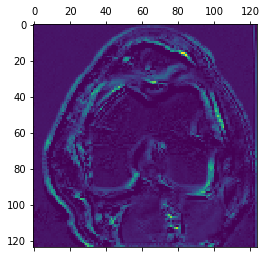

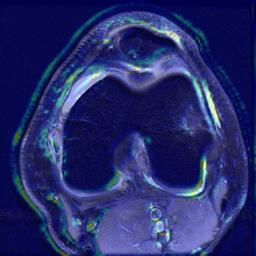

In [56]:
image3 = get_image('axial',46,'hst_amen')
last_conv_layer_name = 'conv2d_3'
heatmap = make_gradcam_heatmap(image3, modelcam, last_conv_layer_name)
plt.matshow(heatmap)
plt.show()
save_and_display_gradcam(image3, heatmap)

The above image was classified as a mensicus tear. The model made that prediction based on the highlighted regions of the meniscus, in particular the region at the bottom right. So this made some sense. The highlighted region near the patella (top middle) was incorrectly identified as region of interest.  